# t-SNE tutorial

## imports

In [122]:
from contextlib import ExitStack
import numpy as np
from sklearn.manifold import TSNE
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import MDS, Isomap
from sklearn.manifold import LocallyLinearEmbedding as LLE
import pandas as pd
import os
import codecs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## plotting 

In [149]:
%matplotlib notebook
def draw(parameters, labels, dim=2, cmap_name='brg'):
    keys  = set(labels)
    numeration = list(range(0,len(keys)))
    label_map = dict(zip(keys,numeration))
    cx = [label_map[l] for l in labels] 
    if(dim==3):
        x = parameters[:,0]
        y = parameters[:,1]
        z = parameters[:,2]
        fig = plt.figure()
        ax = Axes3D(fig)
        ax.scatter(x, y, z, c=cx, cmap=plt.get_cmap(cmap_name))
    else:
        x = parameters[:,0]
        y = parameters[:,1]
        fig = plt.figure(figsize=(8,8))
        plt.scatter(x, y, c=cx, cmap=plt.get_cmap(cmap_name))

## manifold methods

In [124]:
def scale_data(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data)

def perform_pca(data, number_of_components, scale=False):
    if scale:
        data = scale_data(data)
    pca = PCA(n_components=number_of_components)
    components = pca.fit_transform(data)
    components_dataframe = pd.DataFrame(data=components)
    return components_dataframe

def perform_kernel_pca(data, number_of_components, scale=False):
    if scale:
        data = scale_data(data)
    kpca = KernelPCA(kernel="rbf", n_components=number_of_components)
    components = kpca.fit_transform(data)
    components_dataframe = pd.DataFrame(data=components)
    return components_dataframe

def perform_mds(data, number_of_components, scale=False):
    if scale:
        data = scale_data(data)
    mds = MDS(n_components=number_of_components)
    components = mds.fit_transform(data)
    components_dataframe = pd.DataFrame(data=components)
    return components_dataframe
    
def perform_isomap(data, number_of_components, number_of_neighbors, scale=False):
    if scale:
        data = scale_data(data)
    iso = Isomap(n_neighbors=number_of_neighbors, n_components=number_of_components)
    components = iso.fit_transform(data)
    components_dataframe = pd.DataFrame(data=components)
    return components_dataframe

def perform_lle(data, number_of_components, number_of_neighbors, scale=False):
    if scale:
        data = scale_data(data)
    lle = LLE(n_neighbors=number_of_neighbors, n_components=number_of_components)
    components = lle.fit_transform(data)
    components_dataframe = pd.DataFrame(data=components)
    return components_dataframe

In [125]:
def perform_tsne(data, number_of_components, perplex=30.0, scale=False, calc_method='barnes_hut'):
    if scale:
        data = scale_data(data)
    tsne = TSNE(n_components=number_of_components, perplexity=perplex, method=calc_method)
    components = tsne.fit_transform(data)
    components_dataframe = pd.DataFrame(data=components)
    return components_dataframe

## preprocessing

In [126]:
def preprocess_data(filesdir, no_classes): 
    labels = [fname for fname in os.listdir(filesdir) if not fname.startswith('.')]
    dirs = [filesdir + label for label in labels][:no_classes]
    files = [os.listdir(directory) for directory in dirs][:no_classes]
    lengths = [len(f) for f in files]
    multiplied_labels = [[label]*length for label,length in zip(labels,lengths)]
    flat_labels = [x for sublist in multiplied_labels for x in sublist]
    flat_files = [x for sublist in files for x in sublist]
    flat_files = [filesdir + flat_label + '/' + flat_file for flat_label,flat_file in zip(flat_labels,flat_files)]
    filenames = flat_files
    stemmer = SnowballStemmer('english')
    analyzer = TfidfVectorizer().build_analyzer()
    def stemmed_words(doc):
        return (stemmer.stem(w) for w in analyzer(doc))
    with ExitStack() as stack:
    
        files = []
        for fname in filenames:
            with codecs.open(fname, 'r', encoding='utf-8', errors='ignore') as f:
                files.append(stack.enter_context(f).read())
                f.close()
        vectorizer = TfidfVectorizer(stop_words='english', analyzer=stemmed_words)
        vectorized_data = vectorizer.fit_transform(files).todense()
        return vectorized_data, flat_labels
    
def reduce_data(data, labels, factor=0.9):
    bitmap = np.random.rand(len(data)) <= factor
    new_data = np.array(data)[bitmap]
    new_labels = np.array(labels)[bitmap]
    return new_data, new_labels

## preprocessing

In [128]:
Y, labels = preprocess_data("20news-bydate/20news-bydate-train/", 3)
Y, labels = reduce_data(Y, labels, factor=1) # 1 - full dataset 0 - empty dataset
pca = PCA(n_components=20)
components = pca.fit_transform(Y)

## performing t-sne

In [129]:
%%time
data_tsne = perform_tsne(components, 3, 40.0, scale=False)

CPU times: user 1min 3s, sys: 4.06 s, total: 1min 7s
Wall time: 1min 8s


<IPython.core.display.Javascript object>


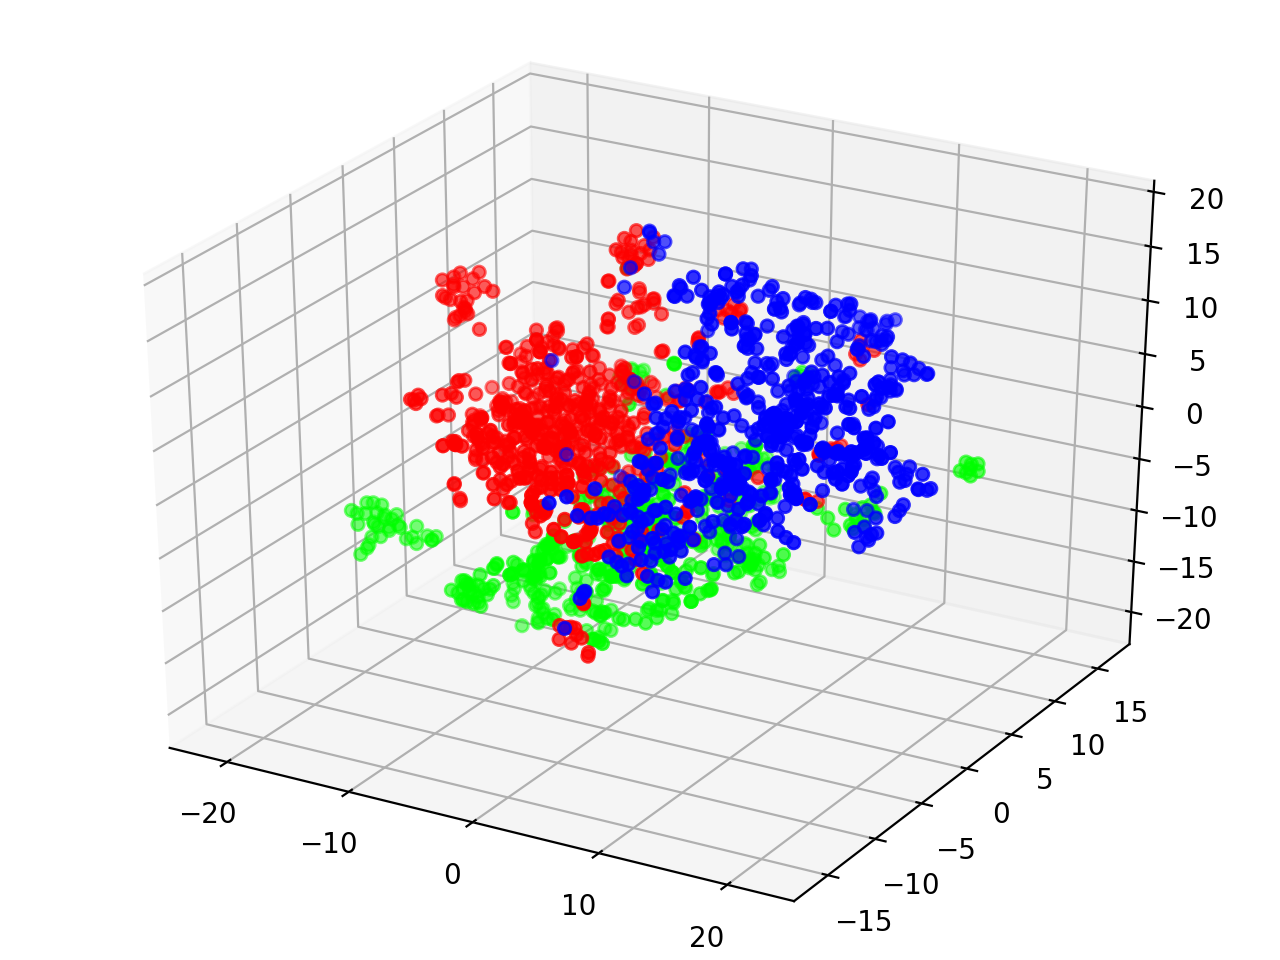

In [150]:
draw(data_tsne.values, labels, dim=3)

# T-sne exercise

In [146]:
Y_ex, labels_ex = preprocess_data("20news-bydate/20news-bydate-train/", 3)
Y_ex, labels_ex = reduce_data(Y, labels, factor=0.2) # 1 - full dataset 0 - empty dataset
pca_ex = PCA(n_components=20)
components_ex = pca_ex.fit_transform(Y)

<IPython.core.display.Javascript object>


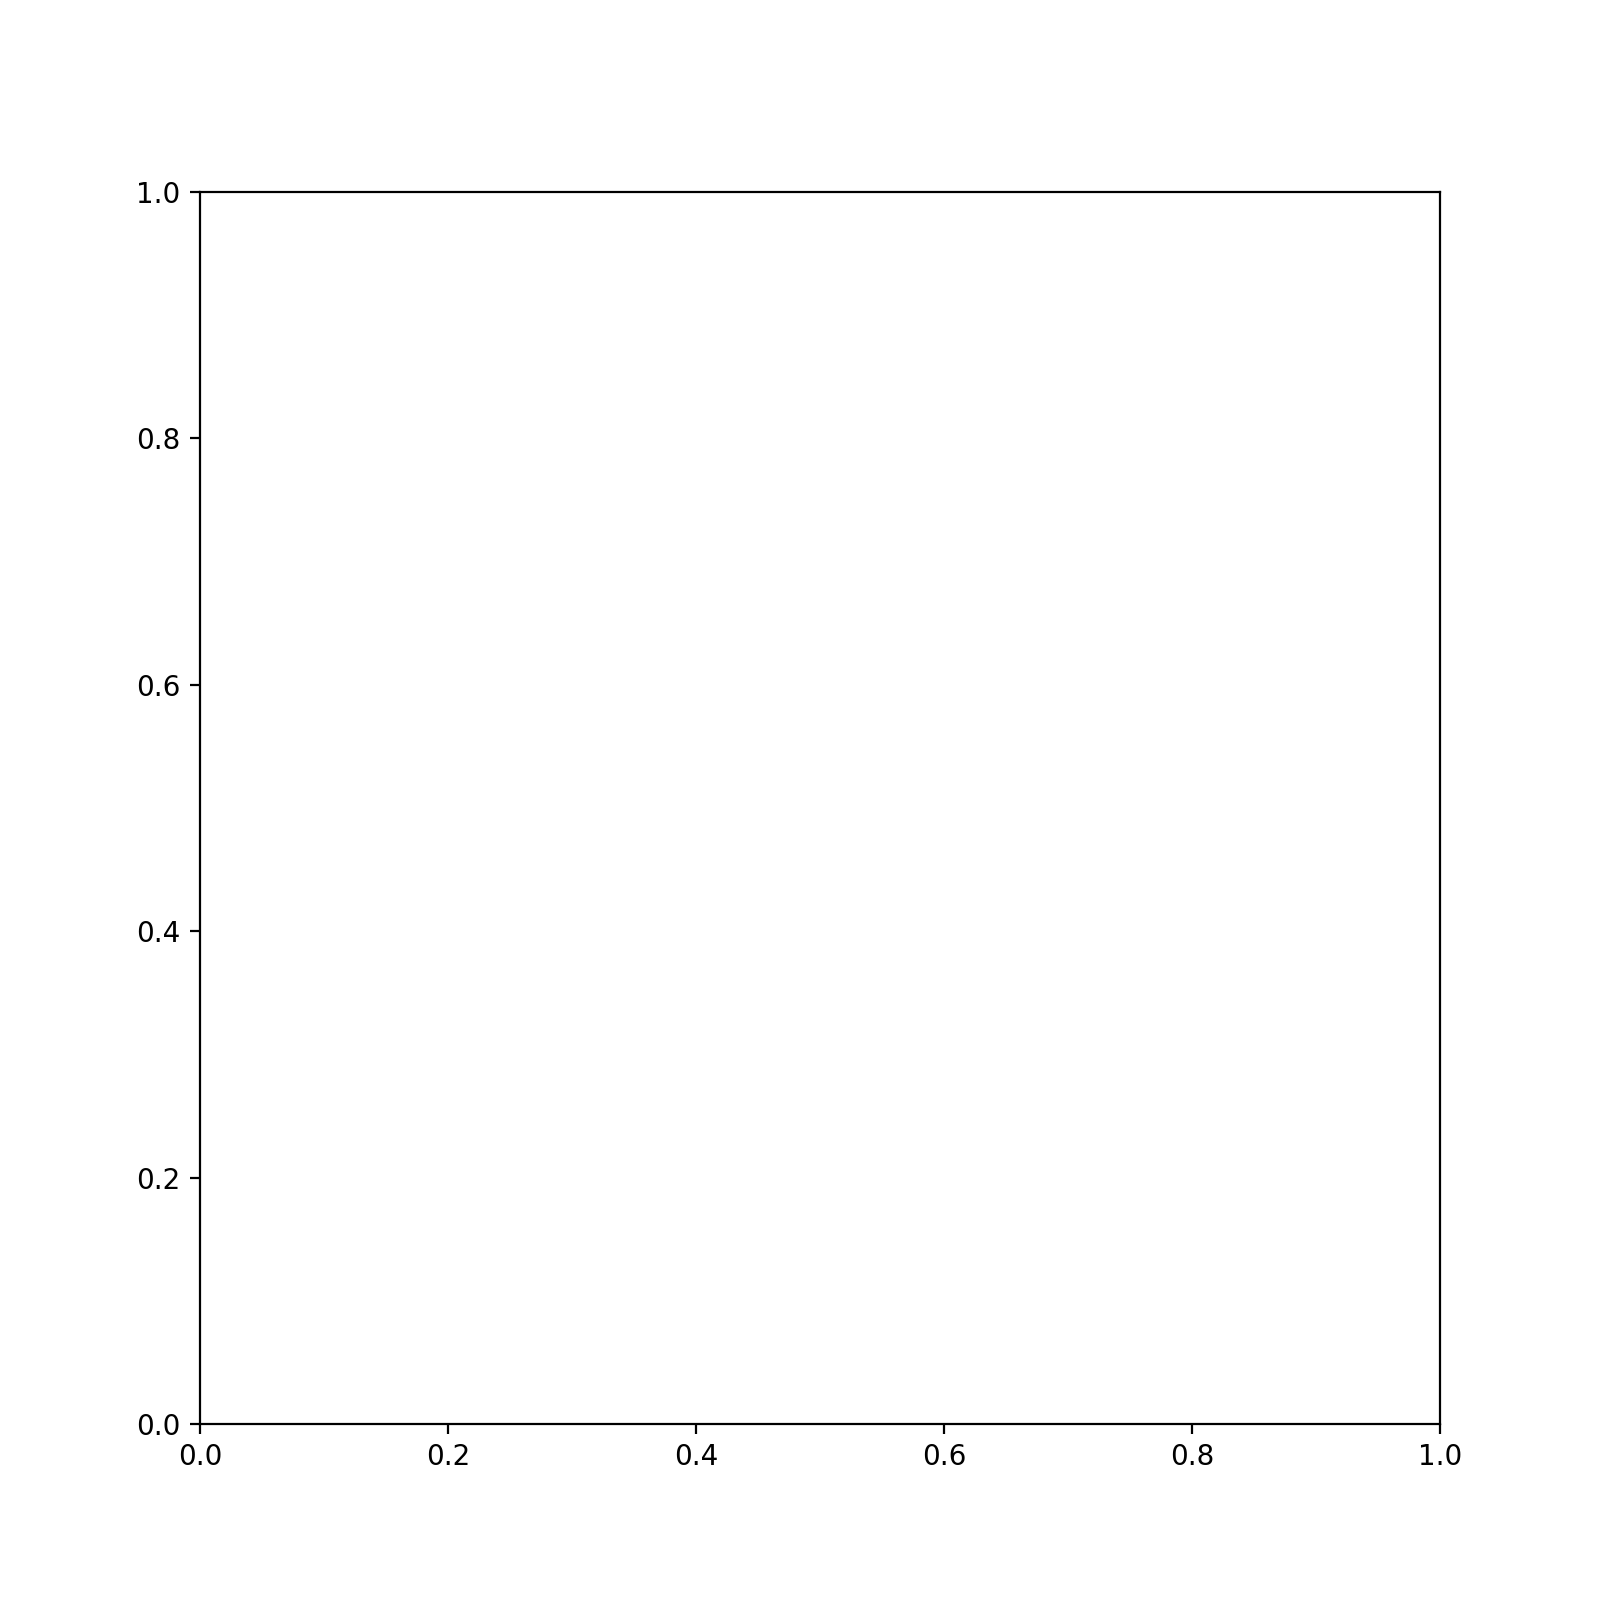

AttributeError: 'list' object has no attribute 'shape'

In [153]:
%%time
for i in range(0,110,10):
    data_tsne_ex = perform_tsne(components_ex, 2, i, scale=False)
    draw(data_tsne_ex.values, labels_ex, dim=2)

# Comparison

In [131]:
%%time
data_exact_tsne = perform_tsne(components, 2, 30.0, calc_method='exact')

CPU times: user 1min 42s, sys: 8.17 s, total: 1min 50s
Wall time: 1min 52s


<IPython.core.display.Javascript object>


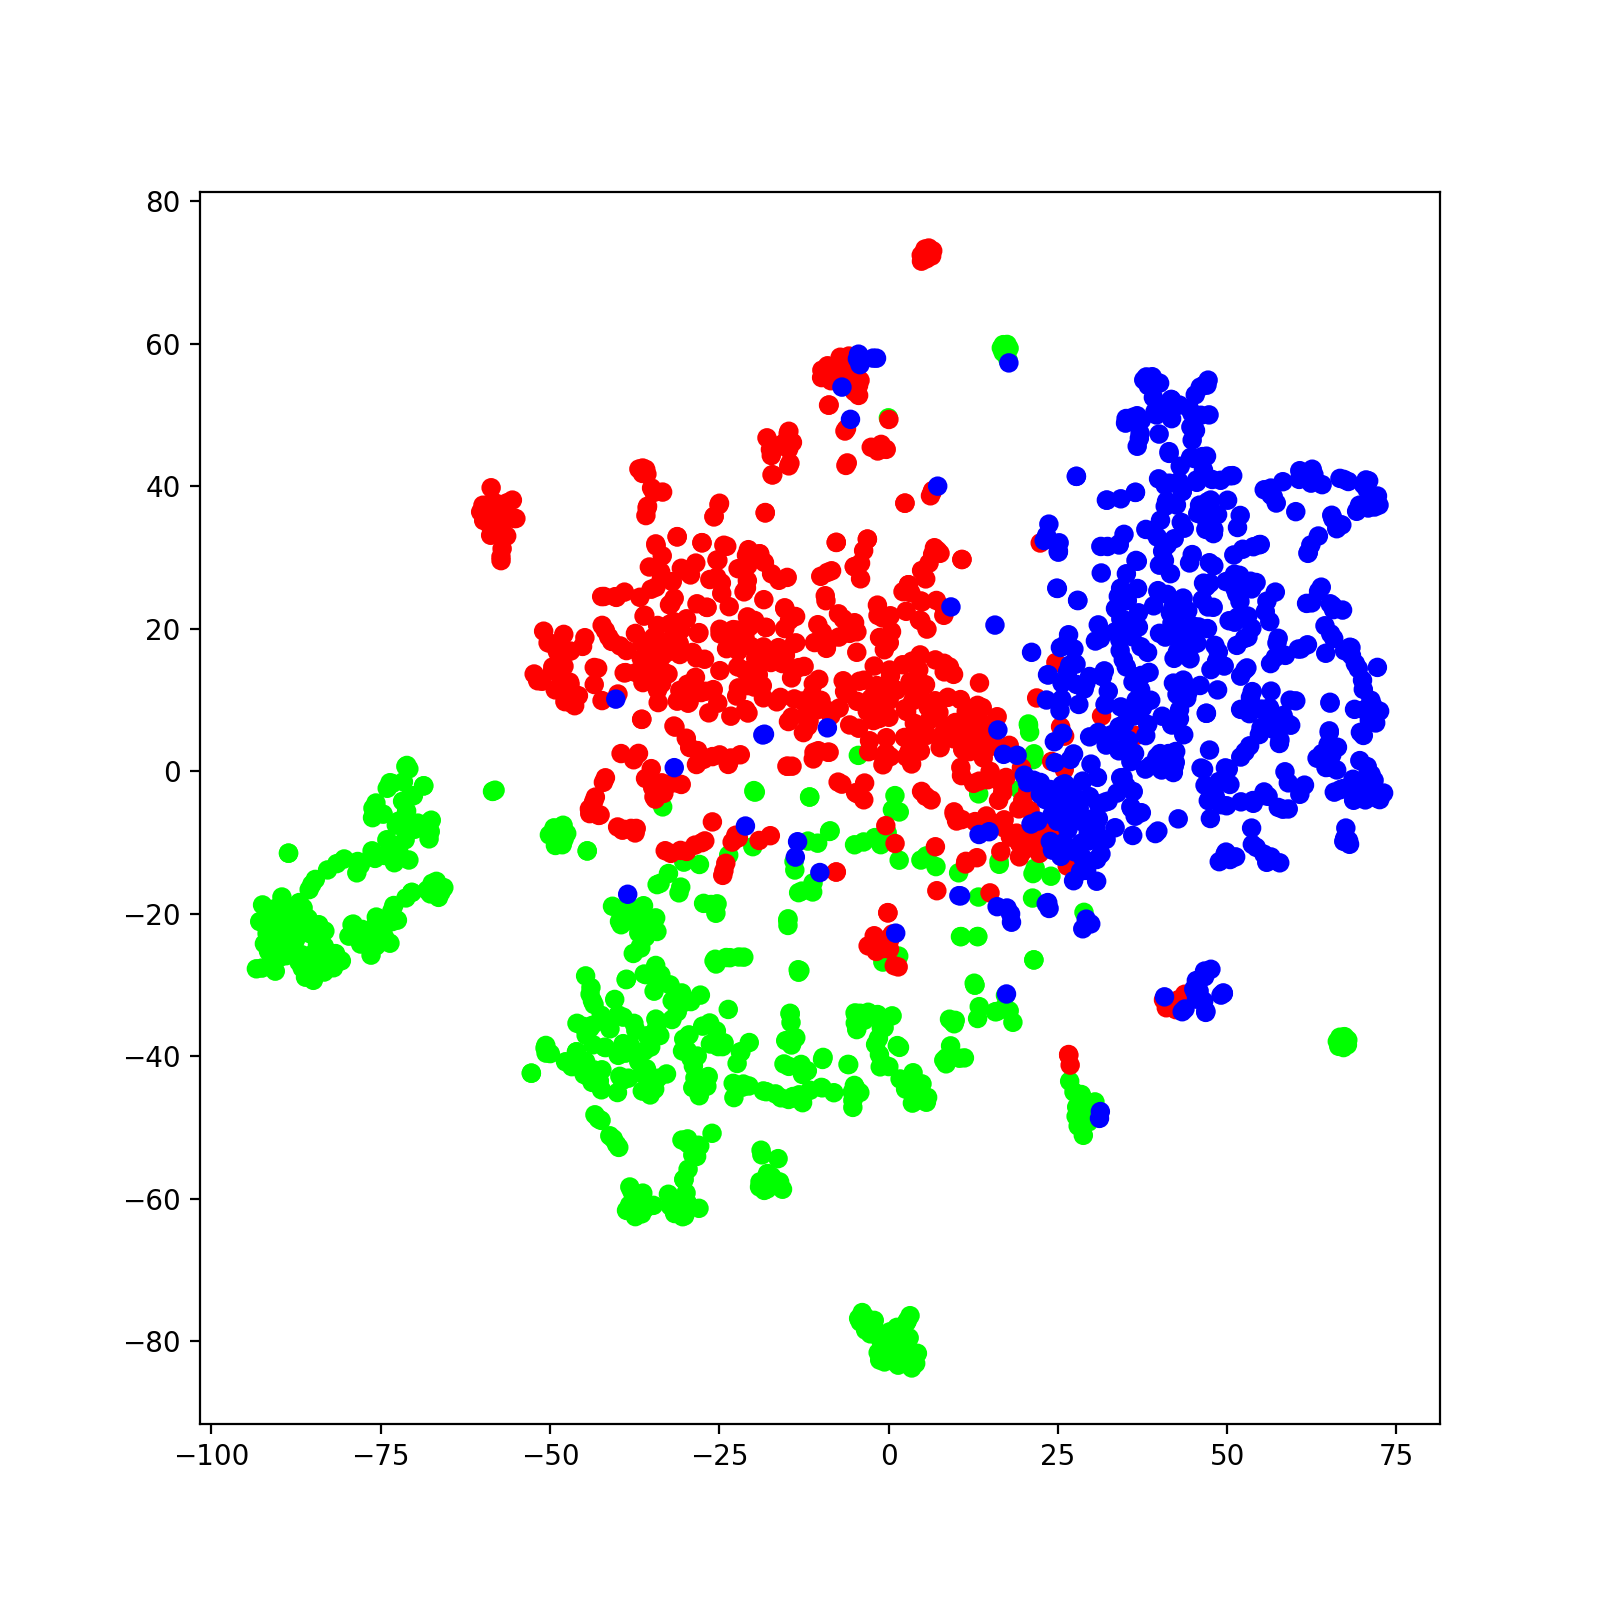

In [132]:
draw(data_exact_tsne.values, labels)

In [133]:
%%time
data_pca = perform_pca(Y, 2)

CPU times: user 4.67 s, sys: 541 ms, total: 5.21 s
Wall time: 2.37 s


<IPython.core.display.Javascript object>


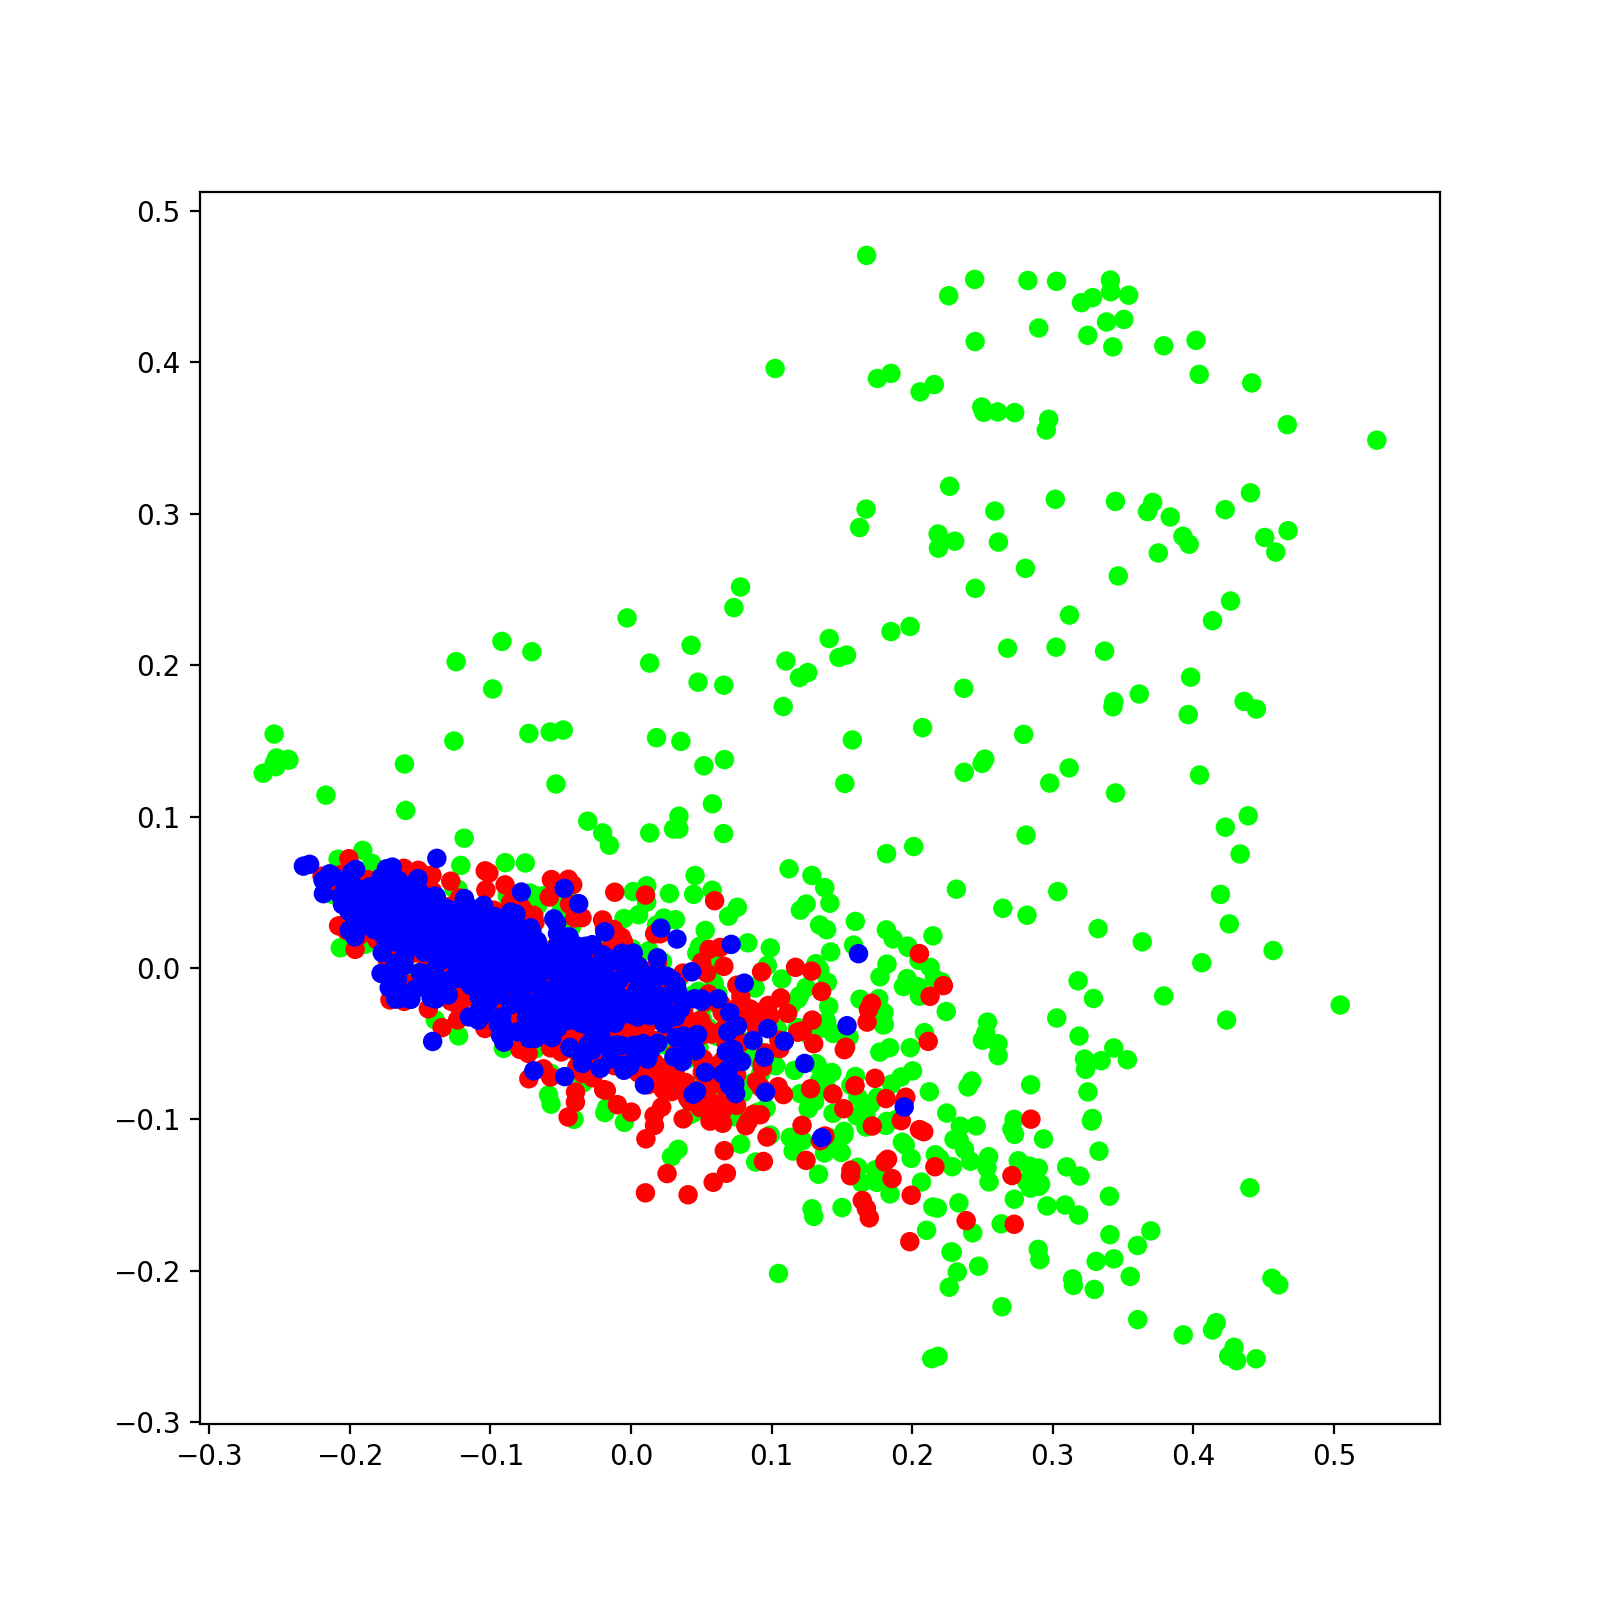

In [134]:
draw(data_pca.values, labels)

In [135]:
%%time
data_kpca = perform_kernel_pca(Y, 2)

CPU times: user 6.55 s, sys: 454 ms, total: 7 s
Wall time: 3.15 s


<IPython.core.display.Javascript object>


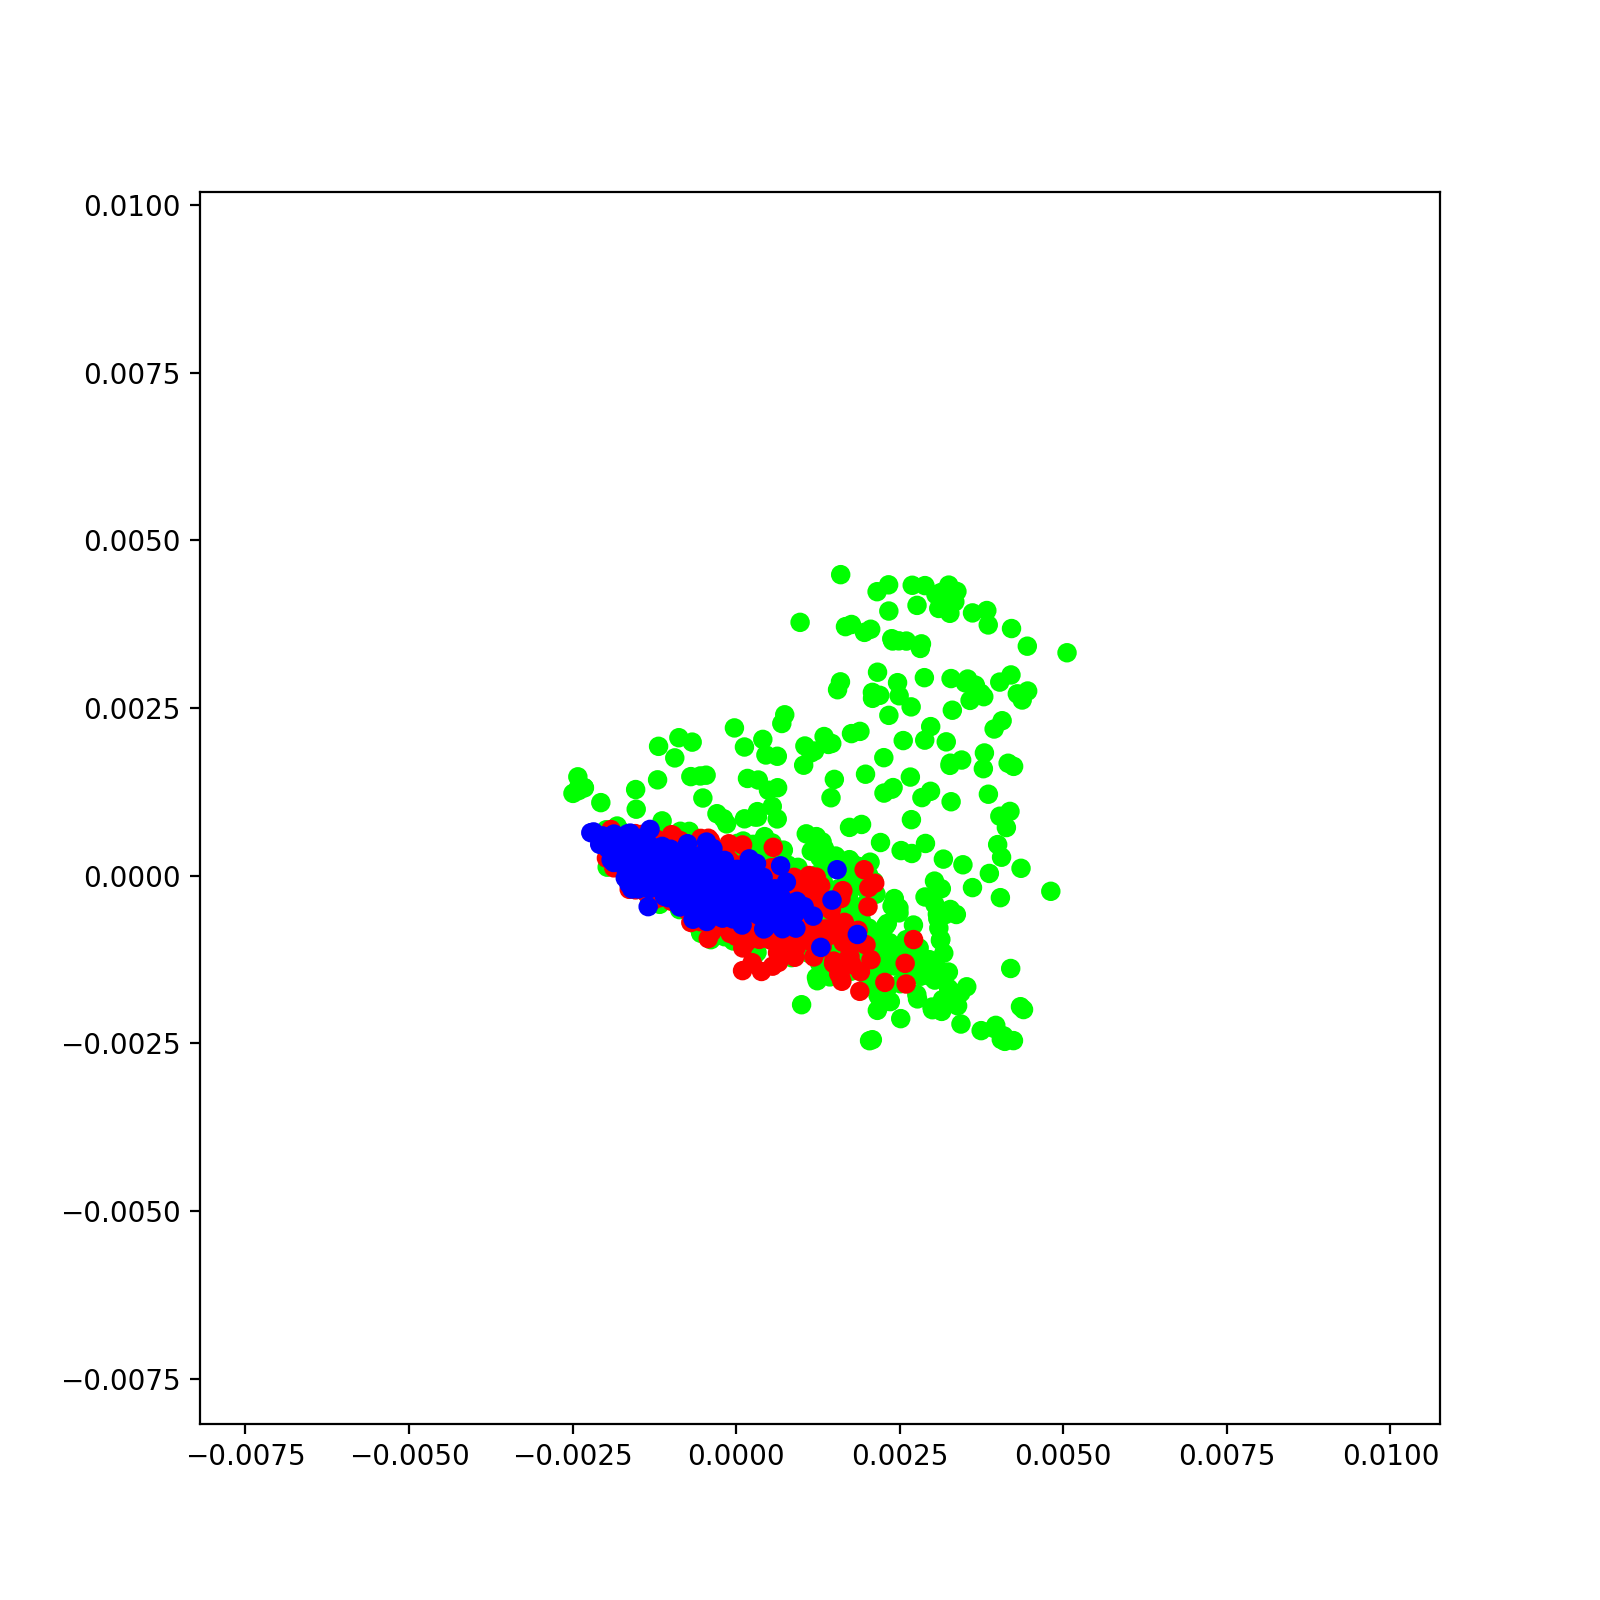

In [136]:
draw(data_kpca.values, labels)

In [137]:
%%time
data_mds = perform_mds(Y, 2)

CPU times: user 1min 20s, sys: 8.11 s, total: 1min 28s
Wall time: 1min 14s


<IPython.core.display.Javascript object>


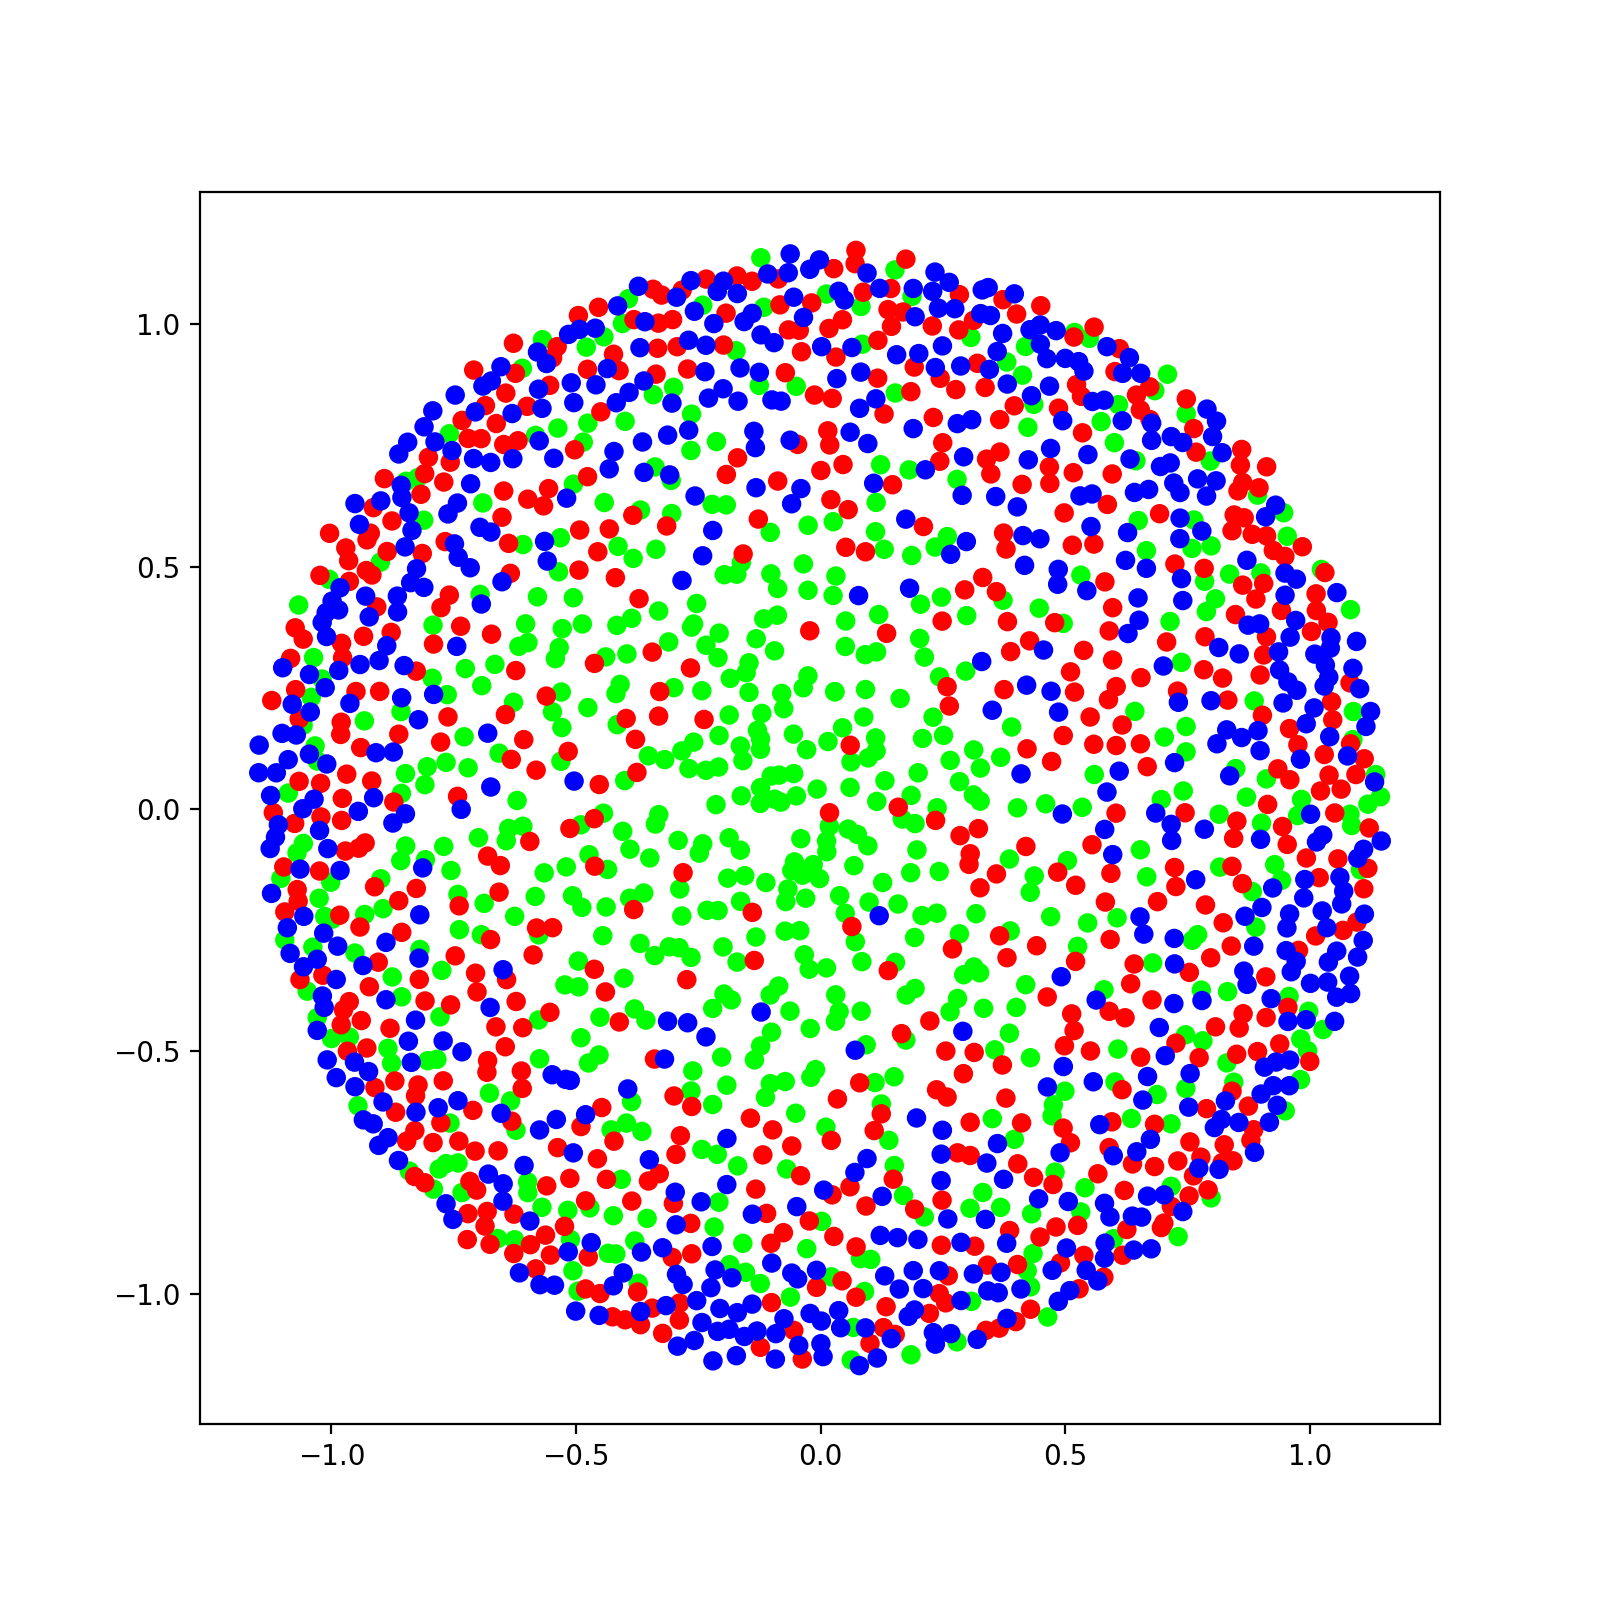

In [138]:
draw(data_mds.values, labels)

In [139]:
%%time
data_lle = perform_lle(Y, 2, 5)

CPU times: user 1min 41s, sys: 2.2 s, total: 1min 43s
Wall time: 1min 46s


<IPython.core.display.Javascript object>


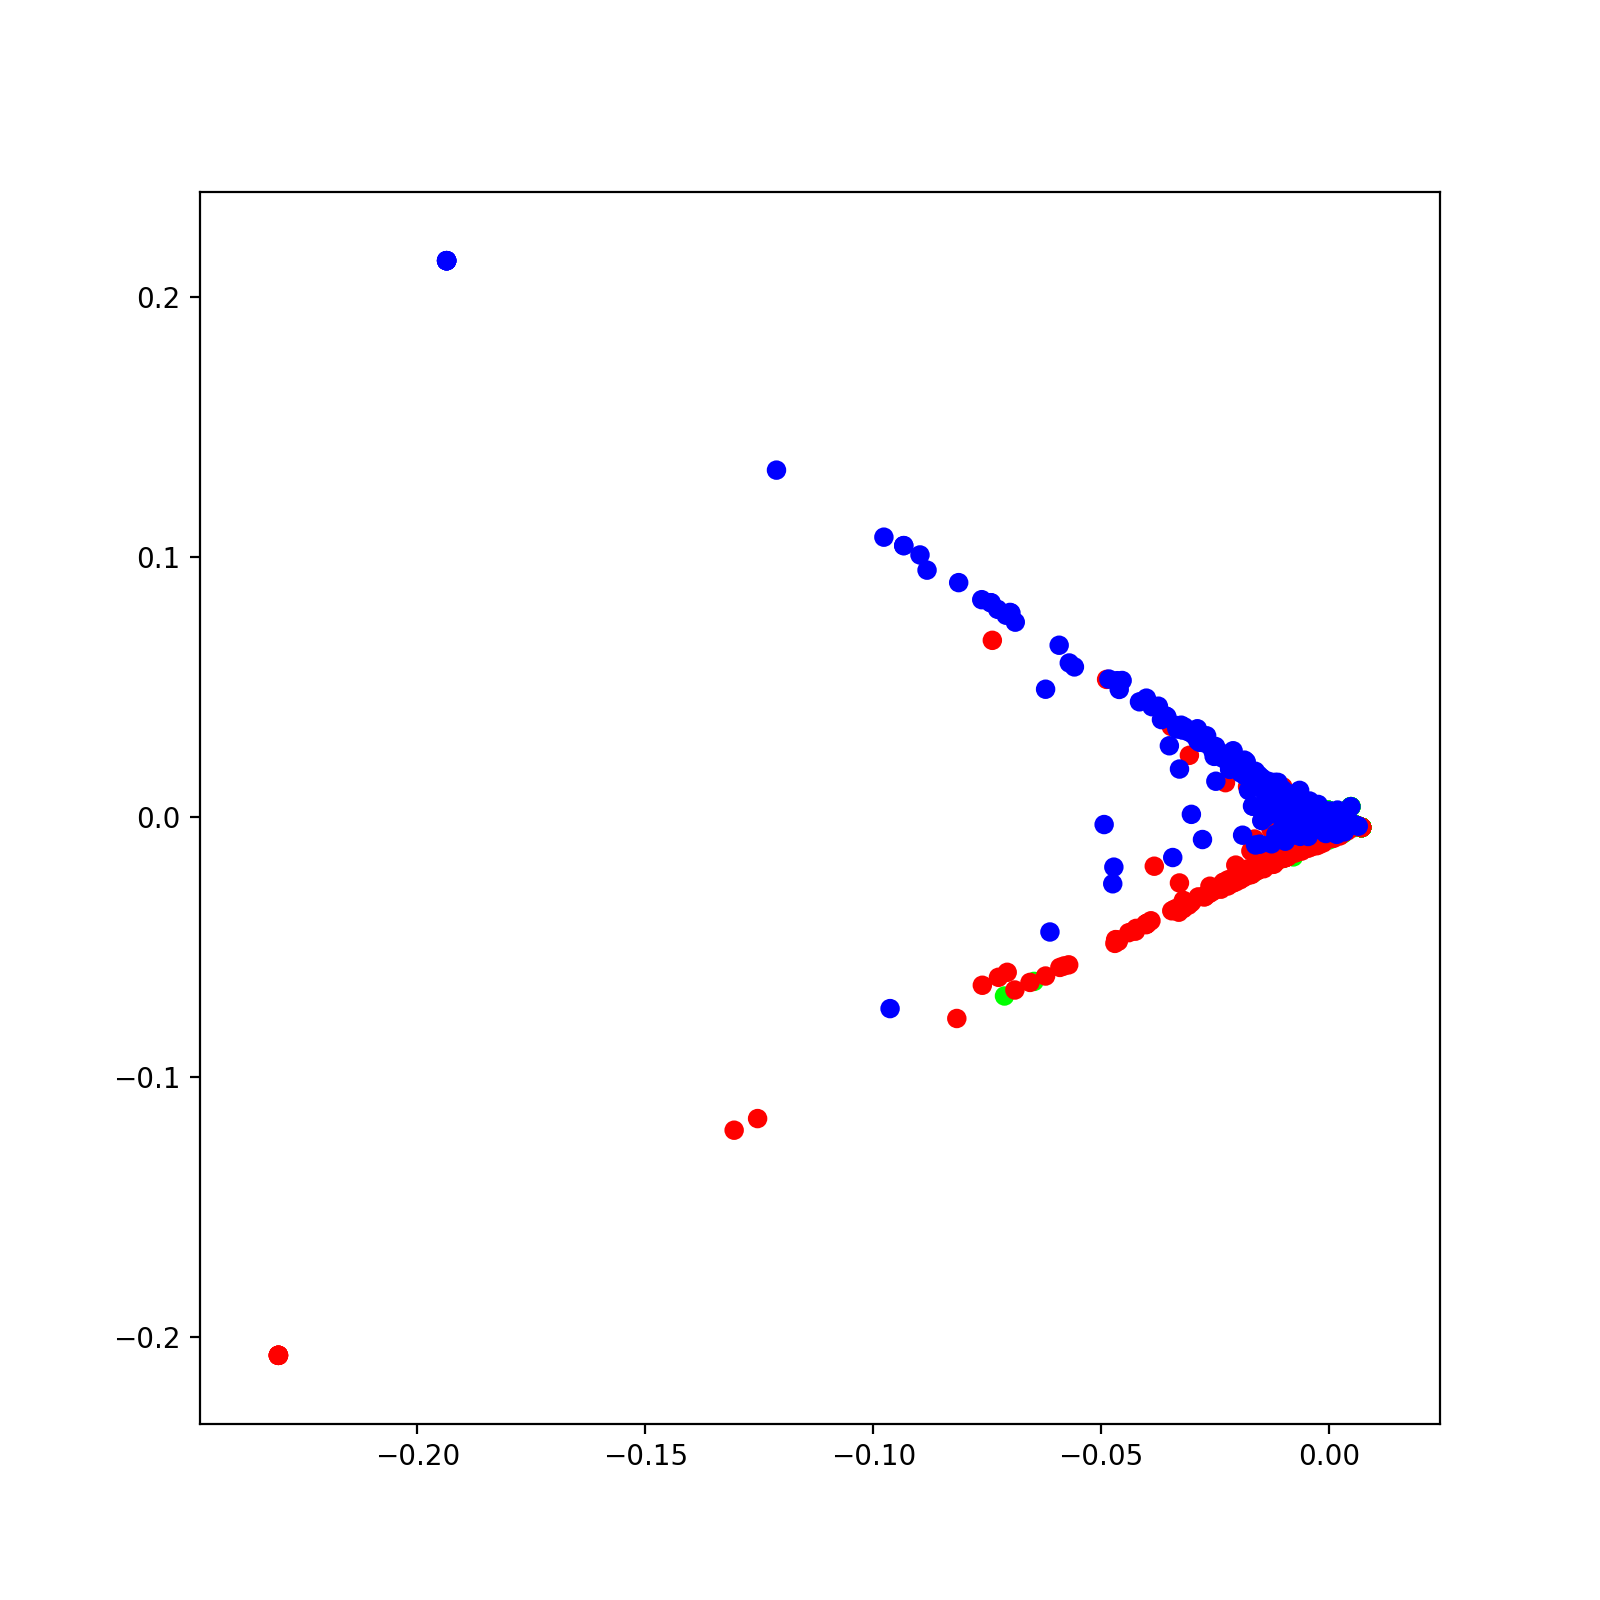

In [140]:
draw(data_lle.values, labels)

In [141]:
%%time
data_isomap = perform_isomap(Y, 2, 5)

CPU times: user 1min 49s, sys: 1.2 s, total: 1min 50s
Wall time: 1min 53s


<IPython.core.display.Javascript object>


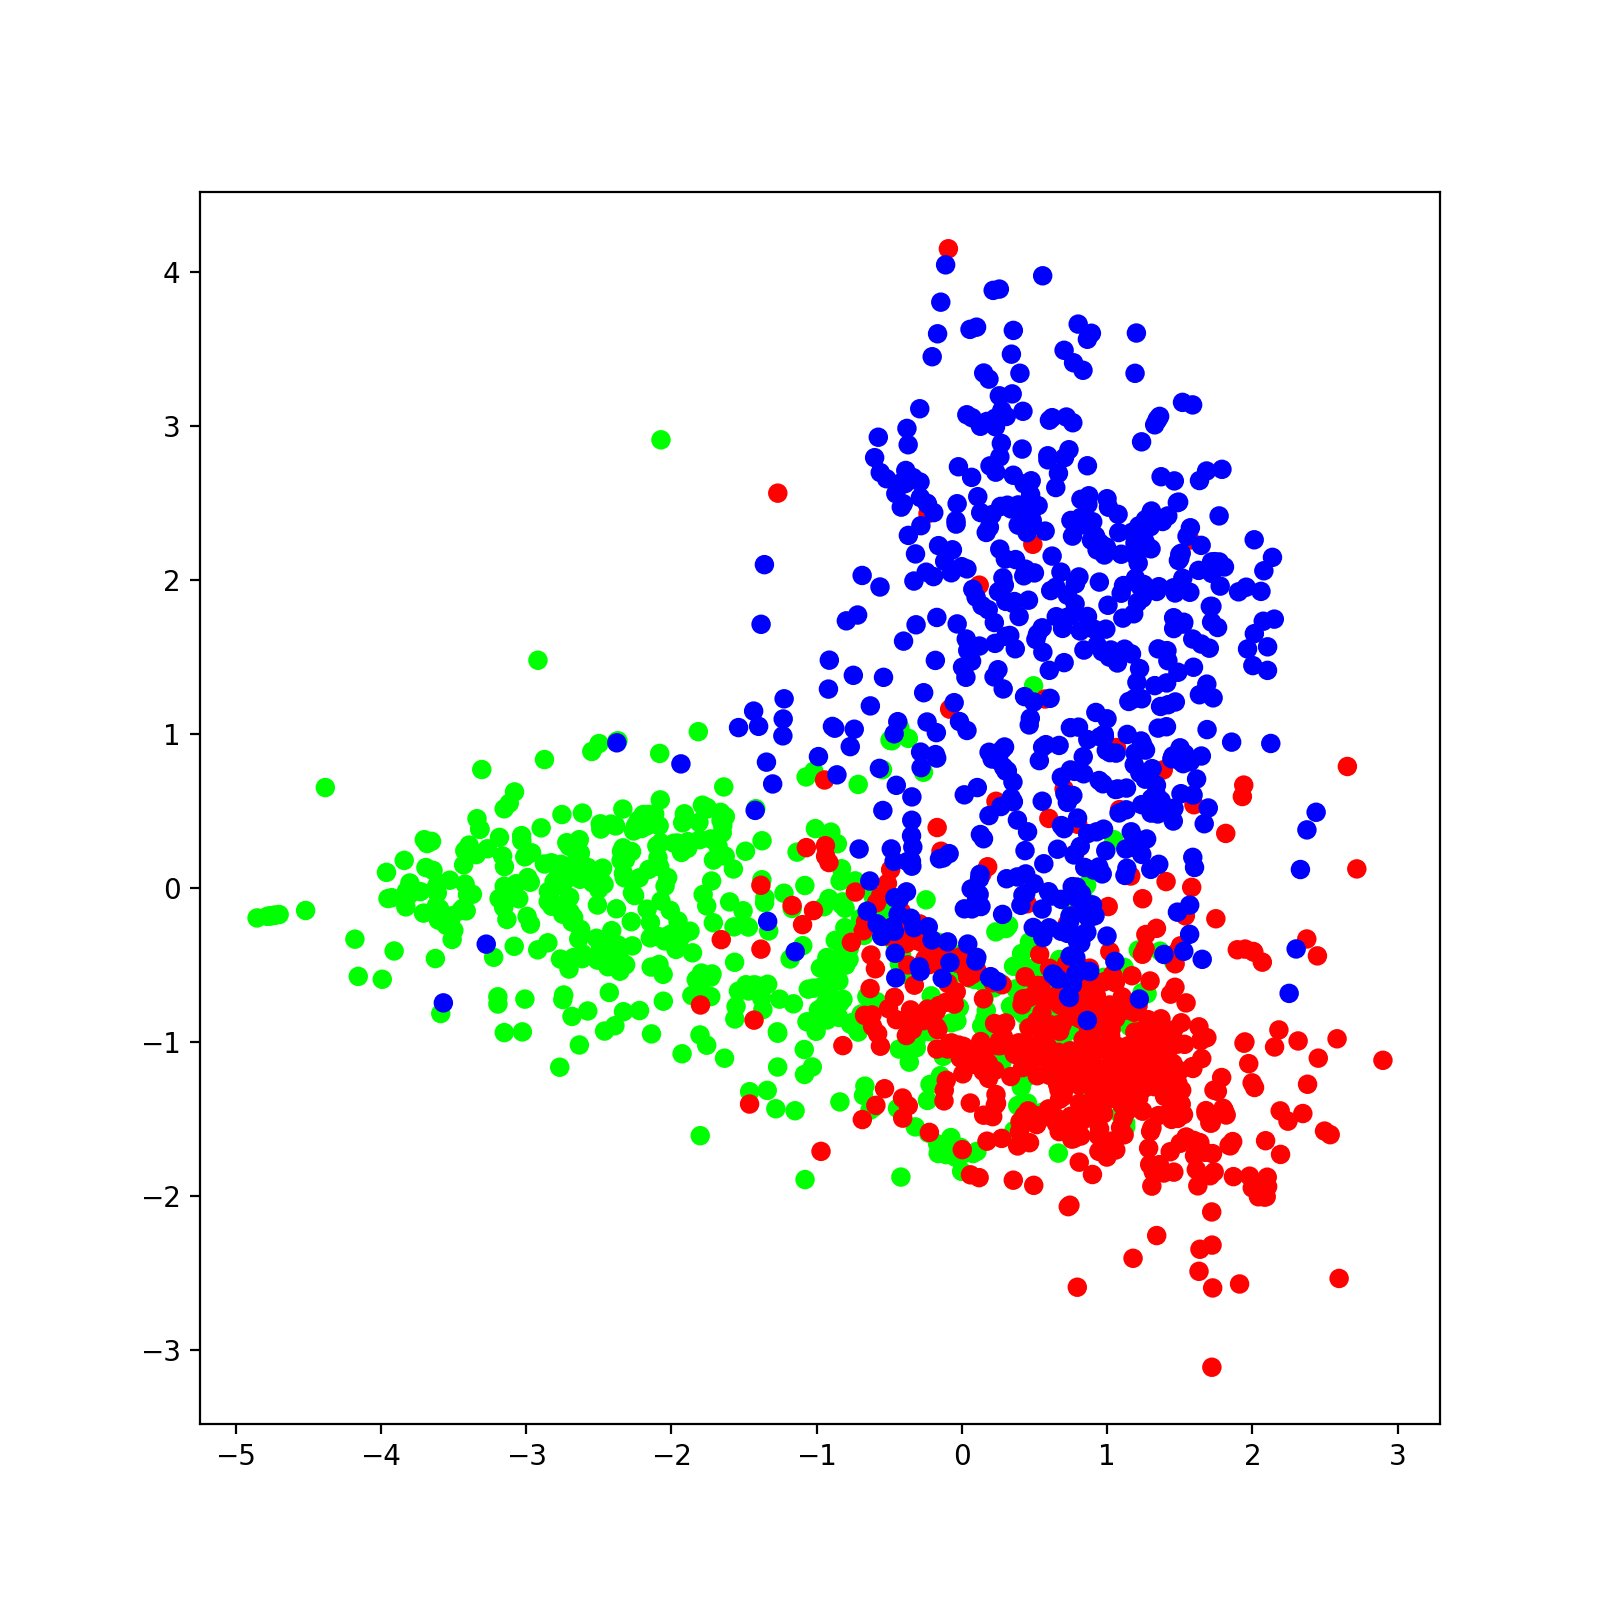

In [142]:
draw(data_isomap.values, labels)

## methods comparison

In [143]:
def knn_stats(samples, labels, n_neighbours):
    nbrs = NearestNeighbors(n_neighbours, algorithm='brute').fit(samples)
    distances, indices = nbrs.kneighbors(samples)
    
    neighbour_stats = []
    
    for index, neighbours in enumerate(indices):
        same_cluster_neighbours = filter(
            lambda neighbour: labels[neighbour] == labels[index],
            neighbours
        )
        neighbour_stats.append(len(list(same_cluster_neighbours)) / n_neighbours)
        
    return neighbour_stats

def k_nearest_neighbors(entry_dataset, computed_dataset, n_neighbors):
    
    nbrs_before = NearestNeighbors(n_neighbors, algorithm='brute').fit(entry_dataset)
    distances_before, indices_before = nbrs_before.kneighbors(entry_dataset)
    
    nbrs_after = NearestNeighbors(n_neighbors, algorithm='brute').fit(computed_dataset)
    distances_after, indices_after = nbrs_after.kneighbors(computed_dataset)
    
    neighbors_hit_list = []
    
    n = len(indices_before)
    
    for i in range(n):
        set_before= set(indices_before[i])
        set_after = set(indices_after[i])
        neighbors_hit_list.append(len(set_before.intersection(set_after)))
        
    return sum(neighbors_hit_list) / len(neighbors_hit_list)

In [144]:
nbors = 10
stats = knn_stats(data_tsne.values, labels, nbors)
print('tsne: ', "%.0f%%" % (100*np.mean(stats)))

stats = knn_stats(data_pca.values, labels, nbors)
print('pca: ', "%.0f%%" % (100*np.mean(stats)))

stats = knn_stats(data_kpca, labels, nbors)
print('kpca: ', "%.0f%%" % (100*np.mean(stats)))

stats = knn_stats(data_mds, labels, nbors)
print('mds: ', "%.0f%%" % (100*np.mean(stats)))

stats = knn_stats(data_lle, labels, nbors)
print('lle: ', "%.0f%%" % (100*np.mean(stats)))

tsne:  92%
pca:  55%
kpca:  54%
mds:  48%
lle:  86%


In [145]:
nbors = 10
stats = k_nearest_neighbors(components, data_tsne.values, nbors)
print('tsne: ', np.mean(stats), ' out of ', nbors, ' neighbors')

stats = k_nearest_neighbors(Y, data_pca.values, nbors)
print('pca: ', np.mean(stats), ' out of ', nbors, ' neighbors')

stats = k_nearest_neighbors(Y,data_kpca.values, nbors)
print('kpca: ', stats, ' out of ', nbors, ' neighbors')

stats = k_nearest_neighbors(Y, data_mds.values, nbors)
print('mds: ', stats, ' out of ', nbors, ' neighbors')

stats = k_nearest_neighbors(Y, data_lle.values, nbors)
print('lle: ', stats, ' out of ', nbors, ' neighbors')

tsne:  6.349654377880184  out of  10  neighbors
pca:  1.3485023041474655  out of  10  neighbors
kpca:  1.3485023041474655  out of  10  neighbors
mds:  1.2350230414746544  out of  10  neighbors
lle:  2.167626728110599  out of  10  neighbors
